In [2]:
# Load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mygene

import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.base import clone

from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, fcluster

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

from matplotlib.patches import Patch
from statsmodels.stats.multitest import multipletests

## 1. Load the expression data and matching metadata from Assignment 2.  

In [3]:
# Load gene expression and metadata into dataframes
expr = pd.read_csv("../data/SRP075806/SRP075806.tsv", sep='\t')
meta = pd.read_csv("../data/SRP075806/metadata_SRP075806.tsv", sep='\t')

# Query mygene for gene names
expr = expr.set_index("Gene")
mg = mygene.MyGeneInfo()
print('Querying...')
res = mg.querymany(expr.index.tolist(), scopes="ensembl.gene", fields="symbol", species="human")

# Mapping dataframe
mapping = (pd.DataFrame(res).loc[:, ["query", "symbol"]].dropna()
             .rename(columns={"query": "Ensembl", "symbol": "GeneName"}))

# Use mapping dataframe to build expression matrix
expr = expr.merge(mapping, left_index=True, right_on="Ensembl")
expr = expr.drop(columns="Ensembl").set_index("GeneName")

# If multiple Ensembl IDs map to the same symbol, combine the rows
expr = expr.groupby(expr.index).mean()

print("Expr.shape (with gene names):", expr.shape, '\n')

expr_log = np.log2(expr+1)


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Querying...


27 input query terms found dup hits:	[('ENSG00000175711', 2), ('ENSG00000188660', 2), ('ENSG00000226506', 2), ('ENSG00000226519', 2), ('E
1224 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116883', 'ENSG00000130489', 'ENSG00000130723', 'ENSG00000131484', 'ENS


Expr.shape (with gene names): (32059, 116) 



## 2. Unsupervised Analysis 

--------------------------------------------------------------------

### Subset most variable genes

In [4]:
# Step 1: Compute variance and select top genes
gene_variances = expr_log.var(axis=1)
gene_variances_sorted = gene_variances.sort_values(ascending=False)

subset_sizes = [10, 100, 1000, 5000, 10000]
gene_subsets = {}

for n in subset_sizes:
    top_genes = gene_variances_sorted.head(n).index
    subset = expr_log.loc[top_genes]
    subset_T = subset.T
    scaler = StandardScaler()
    subset_scaled = scaler.fit_transform(subset_T)
    gene_subsets[n] = pd.DataFrame(subset_scaled, index=subset_T.index, columns=subset_T.columns)
    print(f"Top {n} most variable genes subset:", subset_scaled.shape)

# Step 2: Helper function
def compare_membership_across_k(method, X, k_values):
    """Compare cluster membership similarity across k values for one method."""
    results = {}
    for k in k_values:
        model = clone(method).set_params(n_clusters=k)
        labels = model.fit_predict(X)
        results[k] = labels

    comparison = []
    for (k1, labels1), (k2, labels2) in itertools.combinations(results.items(), 2):
        ari = adjusted_rand_score(labels1, labels2)
        nmi = normalized_mutual_info_score(labels1, labels2)
        comparison.append({"k1": k1, "k2": k2, "ARI": ari, "NMI": nmi})
    return pd.DataFrame(comparison), results

# Use top 5000 genes
X_scaled = gene_subsets[5000].values
k_values = [2, 3, 5, 8, 10]
print("\nUsing top 5000 genes for clustering analysis.")
print("Data shape:", X_scaled.shape)

Top 10 most variable genes subset: (116, 10)
Top 100 most variable genes subset: (116, 100)
Top 1000 most variable genes subset: (116, 1000)
Top 5000 most variable genes subset: (116, 5000)
Top 10000 most variable genes subset: (116, 10000)

Using top 5000 genes for clustering analysis.
Data shape: (116, 5000)


In [5]:
# Step 1: Preprocess and subset
gene_variances = expr_log.var(axis=1)
gene_variances_sorted = gene_variances.sort_values(ascending=False)
subset_sizes = [10, 100, 1000, 5000, 10000]
gene_subsets = {}

for n in subset_sizes:
    top_genes = gene_variances_sorted.head(n).index
    subset = expr_log.loc[top_genes]
    subset_T = subset.T
    scaler = StandardScaler()
    subset_scaled = scaler.fit_transform(subset_T)
    gene_subsets[n] = pd.DataFrame(subset_scaled, index=subset_T.index, columns=subset_T.columns)
    print(f"Top {n} most variable genes subset:", subset_scaled.shape)

# Membership comparison 
def compare_membership_across_k(method, X, k_values):
    results = {}
    for k in k_values:
        model = clone(method)
        # Handle method-specific cluster count parameter
        if hasattr(model, 'n_clusters'):
            model.set_params(n_clusters=k)
        elif hasattr(model, 'n_components'):
            model.set_params(n_components=k)
        else:
            raise ValueError(f"Unknown parameter for {type(model)} to set number of clusters")

        labels = model.fit_predict(X)
        results[k] = labels

    # Compute pairwise comparisons
    rows = []
    for i, k1 in enumerate(k_values):
        for k2 in k_values[i+1:]:
            ari = adjusted_rand_score(results[k1], results[k2])
            nmi = normalized_mutual_info_score(results[k1], results[k2])
            rows.append({'k1': k1, 'k2': k2, 'ARI': ari, 'NMI': nmi})

    df_membership = pd.DataFrame(rows)
    return df_membership, results

# Chi-square comparison
def compare_across_subsets(label_dict):
    """Compare cluster membership across gene subsets using Chi-square tests."""
    results = []
    for (n1, l1), (n2, l2) in itertools.combinations(label_dict.items(), 2):
        contingency = pd.crosstab(l1, l2)
        chi2, p, _, _ = chi2_contingency(contingency)
        results.append({"Subset1": n1, "Subset2": n2, "Chi2": chi2, "p-value": p})
    return pd.DataFrame(results)


Top 10 most variable genes subset: (116, 10)
Top 100 most variable genes subset: (116, 100)
Top 1000 most variable genes subset: (116, 1000)
Top 5000 most variable genes subset: (116, 5000)
Top 10000 most variable genes subset: (116, 10000)


### 2.d.1 K-means

In [6]:
X_scaled = gene_subsets[5000].values
k_values = [2, 3, 5, 8, 10]

df_kmeans_membership, kmeans_labels_k = compare_membership_across_k(
    KMeans(random_state=42),
    X_scaled,
    k_values
)
print("\nK-Means: Cluster membership similarity across k values:")
display(df_kmeans_membership)



K-Means: Cluster membership similarity across k values:


,k1,k2,ARI,NMI
0,2,3,0.435292,0.605582
1,2,5,0.255768,0.455562
2,2,8,0.092715,0.318736
3,2,10,0.084745,0.299582
4,3,5,0.690331,0.808957
5,3,8,0.297494,0.607758
6,3,10,0.274452,0.577198
7,5,8,0.388734,0.677723
8,5,10,0.353417,0.647733
9,8,10,0.953005,0.963364


### 2.d.2 Gaussian Mixture Models

In [7]:
#NOTE takes ~5 minutes to run
df_gmm_membership, gmm_labels_k = compare_membership_across_k(
    GaussianMixture(covariance_type='full', random_state=42),
    X_scaled,
    k_values
)
print("\nGMM: Cluster membership similarity across k values:")
display(df_gmm_membership)



GMM: Cluster membership similarity across k values:


,k1,k2,ARI,NMI
0,2,3,0.435292,0.605582
1,2,5,0.255768,0.455562
2,2,8,0.092715,0.318736
3,2,10,0.084745,0.299582
4,3,5,0.690331,0.808957
5,3,8,0.297494,0.607758
6,3,10,0.274452,0.577198
7,5,8,0.388734,0.677723
8,5,10,0.353417,0.647733
9,8,10,0.953005,0.963364


### 2.d.3 Agglomerative Clustering

In [8]:
df_agg_membership, agg_labels_k = compare_membership_across_k(
    AgglomerativeClustering(linkage='ward'),
    X_scaled,
    k_values
)
print("\nAgglomerative: Cluster membership similarity across k values:")
display(df_agg_membership)



Agglomerative: Cluster membership similarity across k values:


,k1,k2,ARI,NMI
0,2,3,0.303670,0.547487
1,2,5,0.131456,0.378575
2,2,8,0.079814,0.308764
3,2,10,0.064403,0.284939
4,3,5,0.564244,0.765008
5,3,8,0.376876,0.652618
6,3,10,0.313468,0.611860
7,5,8,0.742794,0.877620
8,5,10,0.642178,0.831481
9,8,10,0.889185,0.952890


### 2.d.4 Spectral Clustering

In [9]:
df_spectral_membership, spectral_labels_k = compare_membership_across_k(
    SpectralClustering(affinity='nearest_neighbors', random_state=42),
    X_scaled,
    k_values
)
print("\nSpectral: Cluster membership similarity across k values:")
display(df_spectral_membership)



Spectral: Cluster membership similarity across k values:


/Users/tatumbowen/PycharmProjects/cgs4144_project_git/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/tatumbowen/PycharmProjects/cgs4144_project_git/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/tatumbowen/PycharmProjects/cgs4144_project_git/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/tatumbowen/PycharmProjects/cgs4144_project_git/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/tatumbowen/PycharmProjects/cgs4144_pr

,k1,k2,ARI,NMI
0,2,3,0.582235,0.676847
1,2,5,0.170599,0.400901
2,2,8,0.079814,0.308764
3,2,10,0.064403,0.284939
4,3,5,0.370110,0.657806
5,3,8,0.183824,0.526048
6,3,10,0.149896,0.490318
7,5,8,0.616616,0.842737
8,5,10,0.525941,0.797130
9,8,10,0.889185,0.952890


### 2.d.5 Affinity Propagation

In [10]:
affprop = AffinityPropagation(random_state=42)
aff_labels = affprop.fit_predict(X_scaled)
print(f"Affinity Propagation found {len(np.unique(aff_labels))} clusters")

# Vary preference to change k
for pref in [-50, -10, 0, 10]:
    affprop = AffinityPropagation(preference=pref, random_state=42)
    labels = affprop.fit_predict(X_scaled)
    print(f"Preference={pref}: {len(np.unique(labels))} clusters found")


Affinity Propagation found 14 clusters
Preference=-50: 116 clusters found
Preference=-10: 116 clusters found
Preference=0: 116 clusters found
Preference=10: 116 clusters found


---------------------------------------------------------------------------------------------------

### 2.e.1 K-means

In [11]:
kmeans_labels_subsets = {}
for n in subset_sizes:
    kmeans = KMeans(n_clusters=5, random_state=42)
    labels = kmeans.fit_predict(gene_subsets[n])
    kmeans_labels_subsets[n] = labels
    print(f"Top {n} genes → {len(np.unique(labels))} clusters found")

df_kmeans_chi = compare_across_subsets(kmeans_labels_subsets)
print("\nK-Means: Chi-squared comparison of cluster membership across gene subsets:")
display(df_kmeans_chi)


Top 10 genes → 5 clusters found
Top 100 genes → 5 clusters found
Top 1000 genes → 5 clusters found
Top 5000 genes → 5 clusters found
Top 10000 genes → 5 clusters found

K-Means: Chi-squared comparison of cluster membership across gene subsets:


,Subset1,Subset2,Chi2,p-value
0,10,100,292.918172,7.452919e-53
1,10,1000,299.560974,3.144535e-54
2,10,5000,348.000000,2.703333e-64
3,10,10000,232.000000,2.496871e-40
4,100,1000,418.769231,4.210111e-79
5,100,5000,282.580645,1.020119e-50
6,100,10000,232.000000,2.496871e-40
7,1000,5000,282.580645,1.020119e-50
8,1000,10000,232.000000,2.496871e-40
9,5000,10000,348.000000,2.703333e-64


### 2.e.2 

In [12]:
#NOTE takes ~5 minutes to run
gmm_labels_subsets = {}
for n in subset_sizes:
    gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(gene_subsets[n])
    gmm_labels_subsets[n] = labels
    print(f"Top {n} genes → {len(np.unique(labels))} clusters found")

df_gmm_chi = compare_across_subsets(gmm_labels_subsets)
print("\nGMM: Chi-squared comparison of cluster membership across gene subsets:")
display(df_gmm_chi)


Top 10 genes → 5 clusters found
Top 100 genes → 5 clusters found
Top 1000 genes → 5 clusters found
Top 5000 genes → 5 clusters found
Top 10000 genes → 5 clusters found

GMM: Chi-squared comparison of cluster membership across gene subsets:


,Subset1,Subset2,Chi2,p-value
0,10,100,292.918172,7.452919e-53
1,10,1000,299.560974,3.144535e-54
2,10,5000,348.000000,2.703333e-64
3,10,10000,232.000000,2.496871e-40
4,100,1000,418.769231,4.210111e-79
5,100,5000,282.580645,1.020119e-50
6,100,10000,232.000000,2.496871e-40
7,1000,5000,282.580645,1.020119e-50
8,1000,10000,232.000000,2.496871e-40
9,5000,10000,348.000000,2.703333e-64


### 2.e.3

In [13]:
agg_labels_subsets = {}
for n in subset_sizes:
    agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
    labels = agg.fit_predict(gene_subsets[n])
    agg_labels_subsets[n] = labels
    print(f"Top {n} genes → {len(np.unique(labels))} clusters found")

df_agg_chi = compare_across_subsets(agg_labels_subsets)
print("\nAgglomerative: Chi-squared comparison of cluster membership across gene subsets:")
display(df_agg_chi)


Top 10 genes → 5 clusters found
Top 100 genes → 5 clusters found
Top 1000 genes → 5 clusters found
Top 5000 genes → 5 clusters found
Top 10000 genes → 5 clusters found

Agglomerative: Chi-squared comparison of cluster membership across gene subsets:


,Subset1,Subset2,Chi2,p-value
0,10,100,320.845672,1.210401e-58
1,10,1000,258.639611,8.715963e-46
2,10,5000,258.639611,8.715963e-46
3,10,10000,258.639611,8.715963e-46
4,100,1000,386.787879,2.131441e-72
5,100,5000,386.787879,2.131441e-72
6,100,10000,386.787879,2.131441e-72
7,1000,5000,464.000000,1.296915e-88
8,1000,10000,464.000000,1.296915e-88
9,5000,10000,464.000000,1.296915e-88


### 2.e.4

In [14]:
hier_labels_subsets = {}
for n in subset_sizes:
    Z = linkage(gene_subsets[n], method='ward')
    labels = fcluster(Z, t=5, criterion='maxclust')
    hier_labels_subsets[n] = labels
    print(f"Top {n} genes → {len(np.unique(labels))} clusters found")

df_hier_chi = compare_across_subsets(hier_labels_subsets)
print("\nHierarchical: Chi-squared comparison of cluster membership across gene subsets:")
display(df_hier_chi)


Top 10 genes → 5 clusters found
Top 100 genes → 5 clusters found
Top 1000 genes → 5 clusters found
Top 5000 genes → 5 clusters found
Top 10000 genes → 5 clusters found

Hierarchical: Chi-squared comparison of cluster membership across gene subsets:


,Subset1,Subset2,Chi2,p-value
0,10,100,320.845672,1.210401e-58
1,10,1000,258.639611,8.715963e-46
2,10,5000,258.639611,8.715963e-46
3,10,10000,258.639611,8.715963e-46
4,100,1000,386.787879,2.131441e-72
5,100,5000,386.787879,2.131441e-72
6,100,10000,386.787879,2.131441e-72
7,1000,5000,464.000000,1.296915e-88
8,1000,10000,464.000000,1.296915e-88
9,5000,10000,464.000000,1.296915e-88


### 2.e.5

In [15]:
spectral_labels_subsets = {}
for n in subset_sizes:
    spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(gene_subsets[n])
    spectral_labels_subsets[n] = labels
    print(f"Top {n} genes → {len(np.unique(labels))} clusters found")

df_spectral_chi = compare_across_subsets(spectral_labels_subsets)
print("\nSpectral: Chi-squared comparison of cluster membership across gene subsets:")
display(df_spectral_chi)


/Users/tatumbowen/PycharmProjects/cgs4144_project_git/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/tatumbowen/PycharmProjects/cgs4144_project_git/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/tatumbowen/PycharmProjects/cgs4144_project_git/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/tatumbowen/PycharmProjects/cgs4144_project_git/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/tatumbowen/PycharmProjects/cgs4144_pr

Top 10 genes → 5 clusters found
Top 100 genes → 5 clusters found
Top 1000 genes → 5 clusters found
Top 5000 genes → 5 clusters found
Top 10000 genes → 5 clusters found

Spectral: Chi-squared comparison of cluster membership across gene subsets:


,Subset1,Subset2,Chi2,p-value
0,10,100,356.650573,4.242885e-66
1,10,1000,356.650573,4.242885e-66
2,10,5000,273.302142,8.369773e-49
3,10,10000,231.294126,3.479321e-40
4,100,1000,464.000000,1.296915e-88
5,100,5000,360.837945,5.671089e-67
6,100,10000,325.265287,1.460653e-59
7,1000,5000,360.837945,5.671089e-67
8,1000,10000,325.265287,1.460653e-59
9,5000,10000,395.807971,2.752323e-74


## 3. Heatmaps and Dendrograms 

/Users/tatumbowen/PycharmProjects/cgs4144_project_git/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/tatumbowen/PycharmProjects/cgs4144_project_git/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


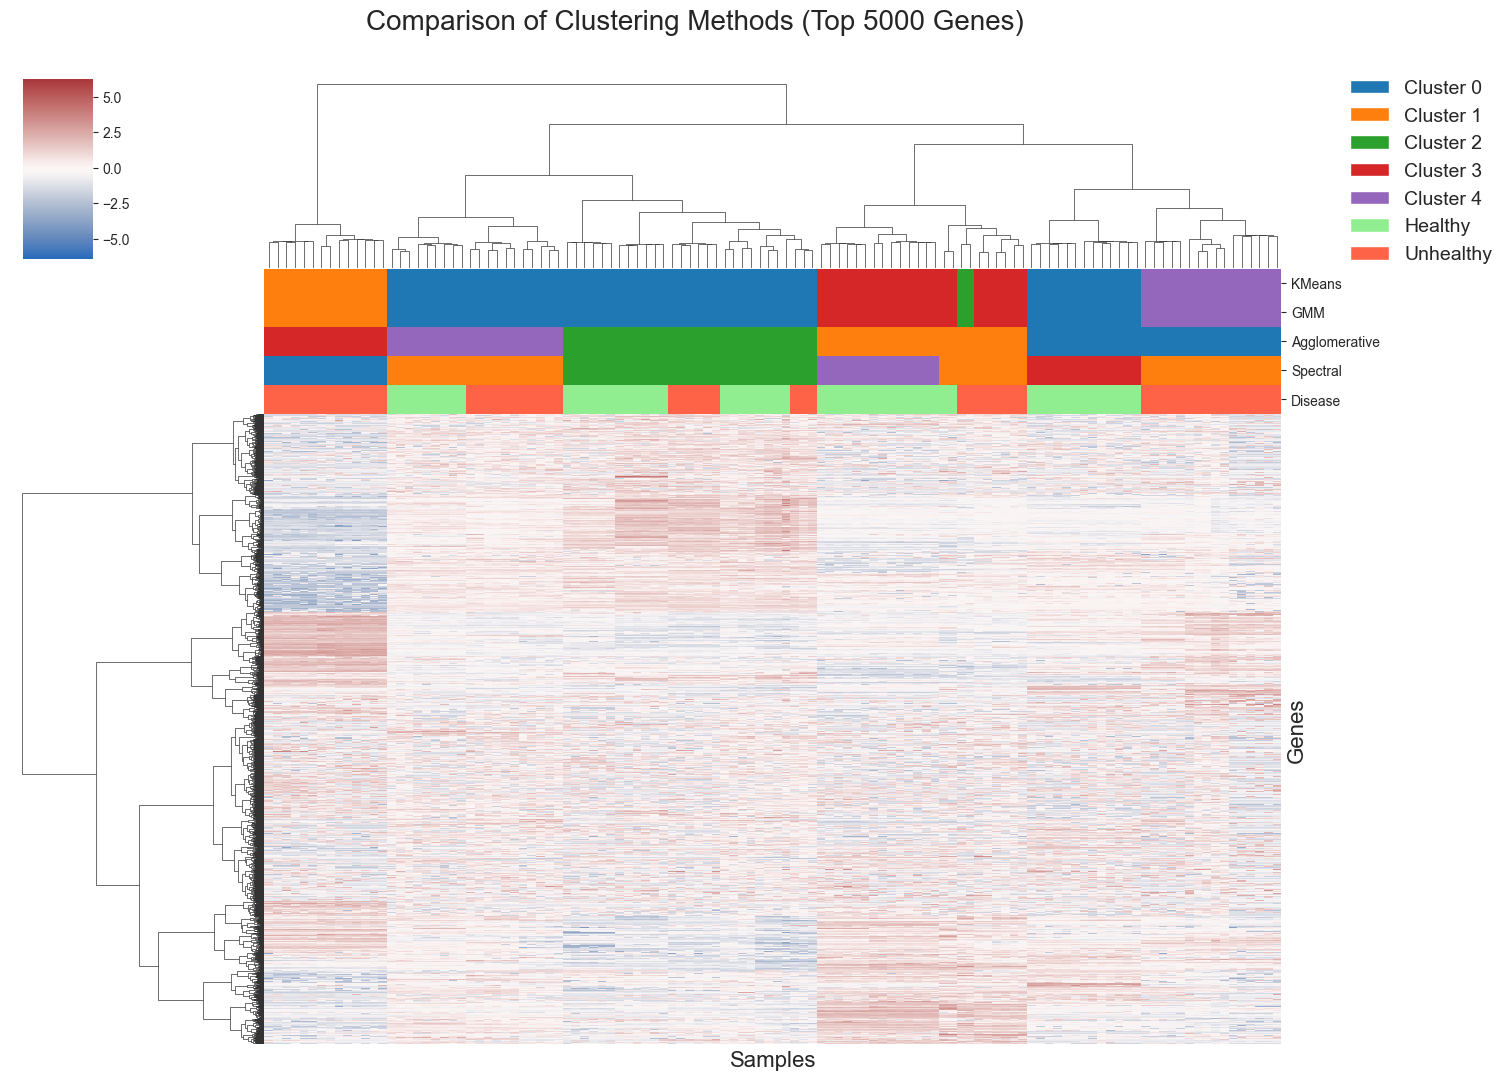

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd

# --- Prepare annotations ---
disease_status = meta.set_index("refinebio_accession_code").loc[
    gene_subsets[5000].index, "refinebio_disease"
].map(lambda x: "Healthy" if x == "ngt" else "Unhealthy")

annotations = pd.DataFrame({
    "KMeans": kmeans_labels_subsets[5000],
    "GMM": gmm_labels_subsets[5000],
    "Agglomerative": agg_labels_subsets[5000],
    "Spectral": spectral_labels_subsets[5000],
    "Disease": disease_status
}, index=gene_subsets[5000].index)

# --- Color palettes ---
k = 5
palette = sns.color_palette("tab10", n_colors=k)
method_colors = {m: dict(zip(range(k), palette)) for m in ["KMeans", "GMM", "Agglomerative", "Spectral"]}
disease_colors = {"Healthy": "lightgreen", "Unhealthy": "tomato"}

row_colors = pd.DataFrame({
    "KMeans": annotations["KMeans"].map(method_colors["KMeans"]),
    "GMM": annotations["GMM"].map(method_colors["GMM"]),
    "Agglomerative": annotations["Agglomerative"].map(method_colors["Agglomerative"]),
    "Spectral": annotations["Spectral"].map(method_colors["Spectral"]),
    "Disease": annotations["Disease"].map(disease_colors)
})

# --- Create clustermap ---
cg = sns.clustermap(
    gene_subsets[5000].T,  # genes as rows, samples as columns
    col_colors=row_colors,
    cmap="vlag",
    metric="euclidean",
    method="ward",
    figsize=(14, 10),
    xticklabels=False,
    yticklabels=False
)

# --- Move title to whitespace above the plot ---
cg.fig.suptitle("Comparison of Clustering Methods (Top 5000 Genes)", fontsize=20, y=1.05)

# --- Axis labels with larger font ---
cg.ax_heatmap.set_xlabel("Samples", fontsize=16)
cg.ax_heatmap.set_ylabel("Genes", fontsize=16)

# --- Build legend for clusters and disease status ---
legend_patches = []

# Cluster colors
for val, color in enumerate(palette):
    legend_patches.append(Patch(facecolor=color, label=f"Cluster {val}"))

# Disease colors
for status, color in disease_colors.items():
    legend_patches.append(Patch(facecolor=color, label=status))

# Place legend to the right with larger font
cg.ax_col_dendrogram.legend(
    handles=legend_patches,
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    prop={"size": 14}  # increase legend font size
)

# --- Show plot ---
plt.show()


## 4. Statistics

In [19]:
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

# helper function to do chi squared
def chi_square_vs_disease(label_dict, disease_series, method):
    results = []
    for n, labels in label_dict.items():
        conting = pd.crosstab(labels, disease_series)
        chi2, p, _, _ = chi2_contingency(conting)
        results.append({
            "Method": method,
            "Subset": n,
            "Chi2": chi2,
            "p-value": p,
        })
    return pd.DataFrame(results)


# run function for each method
df_kmeans_vs_disease = chi_square_vs_disease(kmeans_labels_subsets, disease_status, "KMeans")
df_gmm_vs_disease = chi_square_vs_disease(gmm_labels_subsets, disease_status, "GMM")
df_agg_vs_disease = chi_square_vs_disease(agg_labels_subsets, disease_status, "Agglomerative")
df_spectral_vs_disease = chi_square_vs_disease(spectral_labels_subsets,disease_status, "Spectral")


df_vs_disease = pd.concat([
    df_kmeans_vs_disease,
    df_gmm_vs_disease,
    df_agg_vs_disease,
    df_spectral_vs_disease
], ignore_index=True)

df_vs_disease["Adj_p"] = multipletests(df_vs_disease["p-value"], method="fdr_bh")[1]

# combined for observation
df_all_chi = df_vs_disease.assign(Comparison="Disease vs Clusters")

display(df_vs_disease.sort_values("Adj_p"))

,Method,Subset,Chi2,p-value,Adj_p
18,Spectral,5000,57.694153,8.846585e-12,1.769317e-10
17,Spectral,1000,47.990596,9.480536e-10,4.740268e-09
16,Spectral,100,47.990596,9.480536e-10,4.740268e-09
10,Agglomerative,10,48.333628,8.041078e-10,4.740268e-09
15,Spectral,10,47.211129,1.378056e-09,5.512224e-09
3,KMeans,5000,44.351906,5.421801e-09,1.549086e-08
8,GMM,5000,44.351906,5.421801e-09,1.549086e-08
0,KMeans,10,41.163880,2.485808e-08,5.524018e-08
5,GMM,10,41.163880,2.485808e-08,5.524018e-08
11,Agglomerative,100,40.505747,3.401782e-08,6.803563e-08


## 5. Write a short summary for each plot/table. In 3-5 sentences for each, describe what you did, what parameters you used (if any) and an interesting result from it.

## 6. Combine all results into a single file and submit on Canvas. Make sure that all your code and results are added to the GitHub repository. 